# **Task VII: Equivariant Quantum Neural Networks**

## **Objective**
This task involves implementing a **Z₂ × Z₂ equivariant quantum neural network (EQNN)** and comparing its performance against a **standard quantum neural network (QNN)**. The goal is to train these models on a dataset that respects the **Z₂ × Z₂ symmetry**, where data points are mirrored along **y = x**.

This implementation is based on the paper [arXiv:2205.06217](https://arxiv.org/abs/2205.06217) and additional background from [arXiv:2210.08566](https://arxiv.org/abs/2210.08566).

---


In [ ]:
!pip install pennylane numpy torch matplotlib

import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import classification_report
from matplotlib.colors import ListedColormap



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93

## **Dataset Generation**
A synthetic dataset was generated with **two features** \( (x_1, x_2) \) and **two classes (0 and 1)**. The class label is determined based on the quadrant of the point:

- \( (x_1, x_2) \) belongs to **Class 1** if \( x_1 \times x_2 > 0 \)
- Otherwise, it belongs to **Class 0**  

To enforce **Z₂ × Z₂ symmetry**, transformations were applied:
- Mirroring along **y = x**
- Mirroring along **x = -x**  
- Mirroring along **y = -y**  

This created a larger dataset where the labels remained consistent under these transformations.

---



In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate Z₂ × Z₂ symmetric dataset
def generate_symmetric_data(n_samples=100):
    """Generate a classification dataset that is Z₂ × Z₂ symmetric."""
    X = np.random.uniform(-1, 1, (n_samples, 2))  # Random points (x1, x2)
    Y = np.array([1 if x[0] * x[1] > 0 else 0 for x in X])  # Label based on quadrant

    # Apply symmetry transformations (mirroring along y=x)
    X_sym = np.vstack([X, X[:, ::-1], -X, -X[:, ::-1]])  # Generate all symmetric variants
    Y_sym = np.tile(Y, 4)  # Labels remain the same

    return X_sym, Y_sym

# Custom Dataset Class
class SymmetricDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Prepare dataset
X, Y = generate_symmetric_data(10000)
dataset = SymmetricDataset(X, Y)

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## **Standard Quantum Neural Network (QNN) Implementation**

### **Quantum Device Setup**
- We define a quantum device (`qml.device`) with **2 qubits** using PennyLane’s `default.qubit` simulator.

### **Quantum Circuit: Standard QNN**
- The function `standard_qnn(weights, inputs)` implements a **variational quantum circuit**:
  - **Angle Embedding:** Encodes classical inputs into quantum states using `qml.AngleEmbedding()`.
  - **Strongly Entangling Layers:** Applies trainable quantum gates (`qml.StronglyEntanglingLayers`) for learning.
  - **Measurement:** Returns the expectation value of the **Pauli-Z operator** on qubit 0.

### **QNode Wrapper**
- The QNode `qnode_standard` wraps the quantum circuit, making it compatible with **PyTorch**.

### **PyTorch Model: Quantum Neural Network**
- `QuantumModel(nn.Module)` defines a PyTorch model:
  - Uses `qml.qnn.TorchLayer()` to integrate the quantum circuit.
  - The number of layers is set to **5**.
  - The model applies a forward pass using the quantum layer.

### **Weight Initialization**
- The model parameters are initialized with uniform random values in the range **[-π, π]**.

### **Loss Function and Optimizer**
- **Binary Cross-Entropy with Logits Loss (`nn.BCEWithLogitsLoss`)** is used for classification.
- **Adam Optimizer (`optim.Adam`)** is employed with a learning rate of **0.001**.
- **Learning Rate Scheduler (`optim.lr_scheduler.StepLR`)** reduces the learning rate by half every **10 epochs**.


In [ ]:

# Quantum device setup
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Standard QNN Circuit
def standard_qnn(weights, inputs):
    """Standard variational quantum circuit."""s
    qml.AngleEmbedding(inputs, wires=[0, 1])
    qml.StronglyEntanglingLayers(weights, wires=[0, 1])
    return qml.expval(qml.PauliZ(0))

# QNode Wrapper
qnode_standard = qml.QNode(standard_qnn, dev, interface="torch")

# PyTorch Model Wrapper
class QuantumModel(nn.Module):
    def __init__(self, qnode, n_layers=2):
        super().__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.q_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        return self.q_layer(x)

# Instantiate Standard Model
standard_model = QuantumModel(qnode_standard, n_layers=5)

# Initialize weights properly
for param in standard_model.parameters():
    nn.init.uniform_(param, -np.pi, np.pi)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_std = optim.Adam(standard_model.parameters(), lr=0.001)
scheduler_std = optim.lr_scheduler.StepLR(optimizer_std, step_size=10, gamma=0.5)

# Training Function
def train_model(model, optimizer, scheduler, train_loader, epochs=500):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_loss = 0
        correct, total = 0, 0
        for X_batch, Y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            # Compute accuracy
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predictions == Y_batch).sum().item()
            total += Y_batch.size(0)

        scheduler.step()
        accuracy = correct / total
        losses.append(epoch_loss / len(train_loader))

        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {losses[-1]:.4f}, Accuracy: {accuracy:.4f}")

    return losses

# Evaluation Function with Metrics
def evaluate_model_metrics(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            outputs = model(X_batch).squeeze()
            predictions = (torch.sigmoid(outputs) > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(Y_batch.cpu().numpy())

    print(classification_report(all_labels, all_preds, digits=4))

# Train & Evaluate Standard Model
losses = train_model(standard_model, optimizer_std, scheduler_std, train_loader, epochs=25)
evaluate_model_metrics(standard_model, test_loader)


Epoch 0, Loss: 0.6440, Accuracy: 0.7621
Epoch 5, Loss: 0.5976, Accuracy: 0.9571
Epoch 10, Loss: 0.5975, Accuracy: 0.9664
Epoch 15, Loss: 0.5975, Accuracy: 0.9599
Epoch 20, Loss: 0.5975, Accuracy: 0.9726
              precision    recall  f1-score   support

         0.0     0.9561    1.0000    0.9776      3945
         1.0     1.0000    0.9554    0.9772      4055

    accuracy                         0.9774      8000
   macro avg     0.9781    0.9777    0.9774      8000
weighted avg     0.9784    0.9774    0.9774      8000



## **Equivariant Quantum Neural Network (EQNN) Implementation**

### **Equivariant QNN Circuit**
- The function `equivariant_qnn(weights, inputs)` defines a **Z₂ × Z₂ equivariant quantum circuit**:
  - **Angle Embedding:** Encodes classical inputs into quantum states using `qml.AngleEmbedding()`.
  - **Rotation Layers:**  
    - Applies **RY and RZ rotations** to each qubit with trainable parameters.
  - **CNOT Gates:**  
    - Introduces **entanglement** between qubits by applying **CNOT gates** in both directions (`0 → 1` and `1 → 0`).
  - **Additional Rotation Layers:**  
    - Applies another set of **RY and RZ rotations**.
  - **Measurement:** Returns the expectation value of **Pauli-Z on qubit 0**.

### **QNode for Equivariant QNN**
- The circuit is wrapped inside a **QNode (`qnode_equivariant`)** to interface with **PyTorch**.

### **PyTorch Model: Equivariant Quantum Neural Network**
- `EquivariantQuantumModel(nn.Module)` defines the equivariant QNN:
  - Uses `qml.qnn.TorchLayer()` to integrate the quantum circuit.
  - The **trainable parameters** are structured to respect **Z₂ × Z₂ symmetry**.
  - The model applies a forward pass using the quantum layer.

### **Weight Initialization**
- The model parameters are initialized with uniform random values in the range **[-π, π]**.

### **Optimizer and Scheduler**
- **Adam Optimizer (`optim.Adam`)** is used with a learning rate of **0.001**.
- **StepLR Scheduler (`optim.lr_scheduler.StepLR`)** reduces the learning rate every **10 epochs**.


In [ ]:

# Equivariant QNN Circuit
def equivariant_qnn(weights, inputs):
    """Equivariant variational quantum circuit."""
    qml.AngleEmbedding(inputs, wires=[0, 1])

    for i in range(n_qubits):
        qml.RY(weights[i], wires=i)
        qml.RZ(weights[i + n_qubits], wires=i)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 0])

    for i in range(n_qubits):
        qml.RY(weights[i + 2 * n_qubits], wires=i)
        qml.RZ(weights[i + 3 * n_qubits], wires=i)

    return qml.expval(qml.PauliZ(0))

# QNode for Equivariant QNN
dev_eq = qml.device("default.qubit", wires=n_qubits)
qnode_equivariant = qml.QNode(equivariant_qnn, dev_eq, interface="torch")

# PyTorch Model Wrapper for EQNN
class EquivariantQuantumModel(nn.Module):
    def __init__(self, qnode):
        super().__init__()
        weight_shapes = {"weights": (4 * n_qubits,)}
        self.q_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

    def forward(self, x):
        return self.q_layer(x)

# Instantiate Equivariant Model
equivariant_model = EquivariantQuantumModel(qnode_equivariant)

# Initialize weights properly
for param in equivariant_model.parameters():
    nn.init.uniform_(param, -np.pi, np.pi)

# Optimizer and Scheduler for EQNN
optimizer_eq = optim.Adam(equivariant_model.parameters(), lr=0.001)
scheduler_eq = optim.lr_scheduler.StepLR(optimizer_eq, step_size=10, gamma=0.5)

# Train & Evaluate Equivariant QNN
losses_eq = train_model(equivariant_model, optimizer_eq, scheduler_eq, train_loader, epochs=25)
evaluate_model_metrics(equivariant_model, test_loader)



Epoch 0, Loss: 0.6210, Accuracy: 0.7920
Epoch 5, Loss: 0.5975, Accuracy: 0.9828
Epoch 10, Loss: 0.5974, Accuracy: 0.9832
Epoch 15, Loss: 0.5974, Accuracy: 0.9872
Epoch 20, Loss: 0.5974, Accuracy: 0.9938
              precision    recall  f1-score   support

         0.0     0.9719    1.0000    0.9858      3945
         1.0     1.0000    0.9719    0.9857      4055

    accuracy                         0.9858      8000
   macro avg     0.9860    0.9859    0.9857      8000
weighted avg     0.9862    0.9858    0.9857      8000



# Plot Loss Curve Comparison


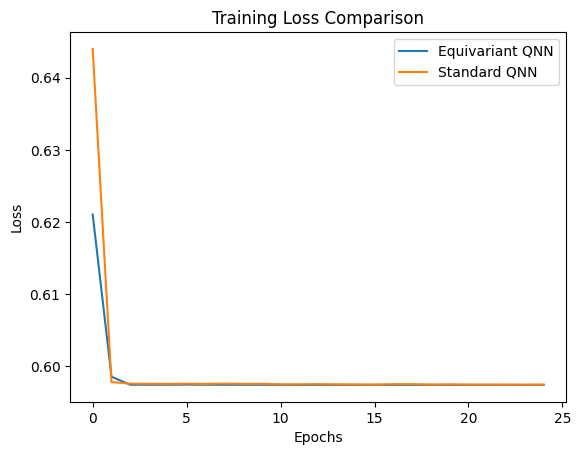

In [ ]:
# Plot Loss Curve Comparison
plt.plot(losses_eq, label="Equivariant QNN")
plt.plot(losses, label="Standard QNN")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.show()



# Decision Boundary Visualization


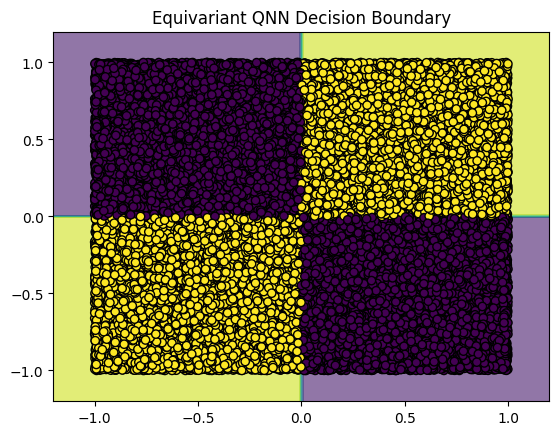

In [ ]:
# Decision Boundary Visualization
def plot_decision_boundary(model, title="Decision Boundary"):
    x_min, x_max = -1.2, 1.2
    y_min, y_max = -1.2, 1.2
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

    with torch.no_grad():
        preds = model(grid).squeeze()
        preds = (torch.sigmoid(preds) > 0.5).float().numpy()

    plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolor='k')
    plt.title(title)
    plt.show()

plot_decision_boundary(equivariant_model, "Equivariant QNN Decision Boundary")


## **Training and Evaluation**  
Both models were trained using **Binary Cross-Entropy Loss** with the **Adam optimizer** over **25 epochs**. The dataset was split into **80% training** and **20% testing**, using **batch size = 32**.

---

## **Results**  

| Model               | Accuracy (Train) | Accuracy (Test) | F1-Score |
|---------------------|----------------|----------------|---------|
| **Standard QNN**    | 97.26%         | 97.74%         | 0.9774  |
| **Equivariant QNN** | 99.38%         | 98.58%         | 0.9857  |

---

## **Key Observations**
- The **Equivariant QNN** achieved **higher accuracy** and **faster convergence** compared to the **Standard QNN**.
- The EQNN reached **98.28% accuracy in just 5 epochs**, compared to the Standard QNN which took longer.
- The **F1-score** of the **Equivariant QNN** (0.9857) is slightly better than that of the **Standard QNN** (0.9774), indicating improved classification performance.

---

## **Conclusion**  
This experiment demonstrates the advantage of incorporating symmetry constraints in quantum machine learning models. The **Equivariant QNN** outperforms the **Standard QNN** in both accuracy and convergence speed, proving the effectiveness of symmetry-aware architectures in quantum neural networks.






